TOMATOE LEAF CLASSIFICATION USING TomatoeNet

---



---




# Importing Libraries

In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import  GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing


Training Image Preprocessing

In [3]:
training_set = tf.keras.utils.image_dataset_from_directory(
     '/content/drive/MyDrive/tomato_data_a/TRAIN',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)

Found 10586 files belonging to 8 classes.


split train dataset into training and validation

In [4]:
# function to split the dataset into training , validation
def get_dataset_partition_tf(ds, train_split = 0.8 , val_split = 0.2):
  ds_size = len(ds)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)
  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  return train_ds, val_ds



Visualizing Training Image with Corresponding Disease Classification Labels


In [5]:
#To view the class names
class_names = training_set.class_names
class_names

['bacterial spot',
 'early blight',
 'healthy',
 'late blight',
 'leaf mold',
 'mosaic virus',
 'septoria spot',
 'yellow leaf curl']

In [6]:
train_ds, val_ds = get_dataset_partition_tf(training_set)

In [7]:
len(train_ds)

264

In [8]:
len(val_ds)

66

In [9]:
training_set = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_set = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# **Validation Data Preprocessing**

In [10]:
training_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>

In [11]:
#getting the total number of training and validation set
print("Lenght of Training set: ",len(training_set))
print("lenght of validation set: ", len(validation_set))

Lenght of Training set:  264
lenght of validation set:  66


In [12]:
for image_batch, label_batch in training_set.take(1):
  print(image_batch[0].shape)
  print(label_batch[np.argmax(label_batch[0])])

(128, 128, 3)
tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0.], shape=(8,), dtype=float32)


In [13]:
for image_batch, label_batch in training_set.take(1):
  print(image_batch[0].numpy().astype("uint8"))
  print(label_batch[np.argmax(label_batch[0])])

[[[ 91  91  91]
  [ 92  92  92]
  [ 91  91  91]
  ...
  [130 129 135]
  [131 130 136]
  [132 131 137]]

 [[ 99  99  99]
  [ 97  97  97]
  [ 99  99  99]
  ...
  [131 130 136]
  [132 131 137]
  [133 132 138]]

 [[ 96  96  96]
  [ 97  97  97]
  [105 105 105]
  ...
  [135 134 140]
  [136 135 141]
  [137 136 142]]

 ...

 [[ 59  59  57]
  [ 61  61  59]
  [ 65  65  63]
  ...
  [171 168 161]
  [172 169 162]
  [172 169 162]]

 [[ 64  64  62]
  [ 67  67  65]
  [ 67  67  65]
  ...
  [170 166 157]
  [169 165 156]
  [168 164 155]]

 [[ 56  57  52]
  [ 60  61  56]
  [ 57  58  53]
  ...
  [171 167 158]
  [169 165 156]
  [166 162 153]]]
tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0.], shape=(8,), dtype=float32)


for x,y in training_set:
    print(x,x.shape)
    print(y,y.shape)
    break


In [14]:
for x,y in training_set:
    print(x,x.shape)
    print(y,y.shape)
    break

tf.Tensor(
[[[[  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]
   ...
   [  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]]

  [[  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]
   ...
   [  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]]

  [[  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]
   ...
   [  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]]

  ...

  [[  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]
   ...
   [  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]]

  [[  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]
   ...
   [  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]]

  [[  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]
   ...
   [  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]]]


 [[[106. 111. 105.]
   [111. 116. 110.]
   [113. 118. 112.]
   ...
   [137. 142. 136.]
   [144. 149. 143.]
   [142. 147. 141.]]

  [[118. 123. 117.]
   [104. 109. 103.]
   [122. 127. 121.]
   ...
   [127. 1

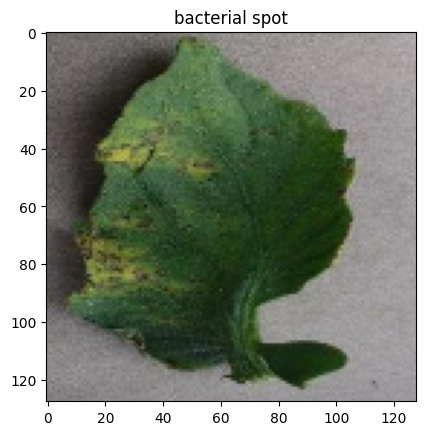

In [15]:
#visualizing a Sample Batch of Training Images with Corresponding Label
for image_batch, label_batch in training_set.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(label_batch[0])])

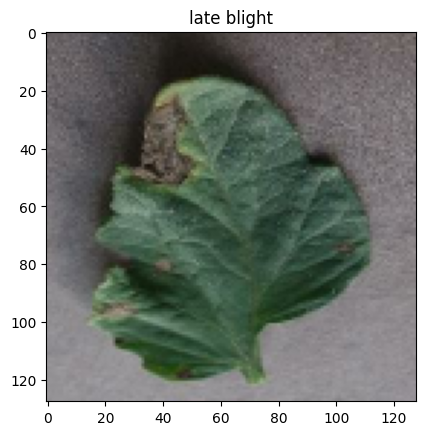

In [16]:
#visualizing a Sample Batch of Training Images with Corresponding Label
for image_batch, label_batch in training_set.take(1):
    plt.imshow(image_batch[1].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(label_batch[0])])

# Building Model

#Building convolutional layer

In [29]:

# Define the model
model = Sequential()

# Block 1: Convolutional Layers + MaxPooling
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=[128, 128, 3]))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

# Block 2: Convolutional Layers + MaxPooling
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

# Block 3: Convolutional Layers + MaxPooling
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

# Regularization and Flattening Layer
model.add(Dropout(0.25))  # Increased dropout rate to reduce overfitting
model.add(Flatten())

# Fully Connected Layers with Dropout and L2 Regularization
model.add(Dense(units=1024, activation='relu', kernel_regularizer=l2(0.01)))  # Added L2 regularization
model.add(Dropout(0.5))
model.add(Dense(units=512, activation='relu', kernel_regularizer=l2(0.01)))  # Added an additional dense layer
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(units=8, activation='softmax'))


# Compiling Model

In [30]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:



# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [32]:
model.summary()
#training_history = model.fit(x=training_set, validation_data=validation_set, epochs=15, callbacks=[early_stopping, lr_scheduler])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │      33,555,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,371,368 (131.12 MB)

 Trainable params: 34,371,368 (131.12 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [34]:

# Fit the model
training_history = model.fit(training_set,
                    validation_data=validation_set,
                    epochs=35,
                    callbacks=[lr_scheduler, early_stopping])


Epoch 1/35
264/264 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.9788 - loss: 0.4013 - val_accuracy: 0.9626 - val_loss: 0.4586 - learning_rate: 1.0000e-04
Epoch 2/35
264/264 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9880 - loss: 0.3605 - val_accuracy: 0.9579 - val_loss: 0.4660 - learning_rate: 1.0000e-04
Epoch 3/35
264/264 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9770 - loss: 0.3926 - val_accuracy: 0.9484 - val_loss: 0.5012 - learning_rate: 1.0000e-04
Epoch 4/35
264/264 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.9850 - loss: 0.3752 - val_accuracy: 0.9659 - val_loss: 0.4336 - learning_rate: 1.0000e-04
Epoch 5/35
264/264 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9891 - loss: 0.3389 - val_accuracy: 0.9593 - val_loss: 0.4266 - learning_rate: 1.0000e-04
Epoch 6/35
264/264 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.9873 - loss: 0.3277 - val_accuracy: 0.9635 - val_loss: 0.4304 - learning_rate: 1.0000e-04
Epoch 7/35
264/264 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/ste

# Model Evaluation


In [35]:
#Training set Accuracy
train_loss, train_acc = model.evaluate(training_set)
print('Training accuracy:', train_acc)


264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 1.0000 - loss: 0.0431
Training accuracy: 1.0


In [36]:
#Validation set Accuracy
val_loss, val_acc = model.evaluate(validation_set)
print('Validation accuracy:', val_acc)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9748 - loss: 0.1211
Validation accuracy: 0.9744318127632141


# saving model

In [37]:
model.save('TomatoeNet_model.keras')

In [38]:
training_history.history #Return Dictionary of history

{'accuracy': [0.9796401262283325,
  0.9817708134651184,
  0.9750236868858337,
  0.9822443127632141,
  0.9848484992980957,
  0.9818891882896423,
  0.9797585010528564,
  0.9817708134651184,
  0.99609375,
  0.9971590638160706,
  0.998106062412262,
  0.9971590638160706,
  0.9911221861839294,
  0.9924242496490479,
  0.9945549368858337,
  0.9938446879386902,
  0.9950284361839294,
  0.9969223737716675,
  0.9984611868858337,
  0.9985795617103577,
  0.9991713762283325,
  0.9986979365348816,
  0.9972774386405945,
  0.9966856241226196,
  0.9983428120613098,
  0.9984611868858337,
  0.9989346861839294,
  0.9996448755264282,
  0.9995265007019043,
  0.9992897510528564,
  0.9994081258773804,
  0.9990530014038086,
  0.9994081258773804,
  0.9996448755264282,
  0.9988163113594055],
 'loss': [0.3979772627353668,
  0.3729757070541382,
  0.41028353571891785,
  0.36881527304649353,
  0.3482440710067749,
  0.34396064281463623,
  0.35170072317123413,
  0.3558894395828247,
  0.28070393204689026,
  0.22758826613

In [39]:

#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)

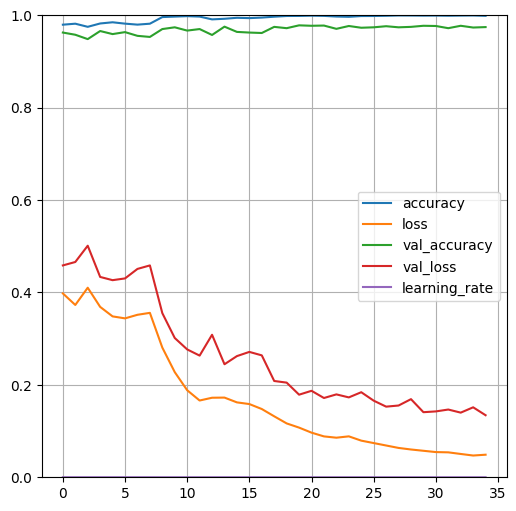

In [40]:
pd.DataFrame(training_history.history).plot(figsize=(6,6))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [41]:
print(training_history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


# Accuracy and Loss Visualization

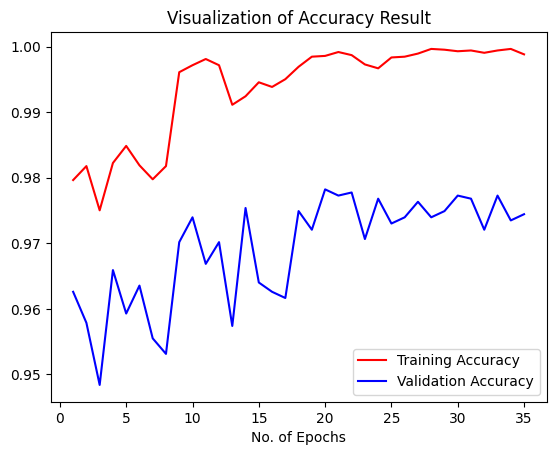

In [51]:
epochs = [i for i in range(1,36)]
plt.plot(epochs,training_history.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(epochs,training_history.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

In [52]:
#To plot loss and accuracy graph
acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

loss = training_history.history['loss']
val_loss = training_history.history['val_loss']

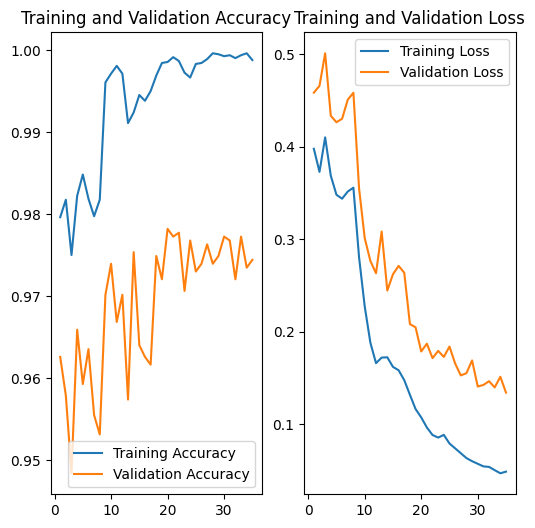

In [53]:
plt.figure(figsize = (6,6))
plt.subplot(1,2,1)
plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(epochs, loss , label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

# To Generate the Performance Metrics on Test Data

In [54]:
test_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/tomato_data_a/TEST',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=1,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 592 files belonging to 8 classes.


In [55]:
#Using the model to predict target labels
y_pred = model.predict(test_set)
predicted_categories = tf.argmax(y_pred, axis=1)


592/592 ━━━━━━━━━━━━━━━━━━━━ 89s 148ms/step


In [56]:
#TO generate actual labels from test set
Y_true = tf.concat([y for x, y in test_set], axis=0)
Maxvalue = tf.argmax(Y_true, axis=1)
actual_categories = Maxvalue.numpy()

In [57]:
actual_categories

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,

In [58]:
predicted_categories = predicted_categories.numpy()
predicted_categories

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,

In [59]:
from sklearn import metrics
print("Accuracy =", metrics.accuracy_score(actual_categories, predicted_categories))

Accuracy = 0.9831081081081081


In [60]:
#To show the prediction and the confidence level
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]

    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [61]:
#Show actual value and predicted value in dataframe
view_pred = pd.DataFrame(list(zip(predicted_categories, actual_categories)))
view_pred.columns = ['Prediction', 'Actual values']
view_pred.head(25)

,Prediction,Actual values
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [62]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(actual_categories,predicted_categories)

In [63]:
# Precision Recall Fscore
print(classification_report(actual_categories,predicted_categories,target_names=class_names))

                  precision    recall  f1-score   support

  bacterial spot       0.99      0.99      0.99        74
    early blight       0.96      0.96      0.96        74
         healthy       1.00      1.00      1.00        74
     late blight       1.00      0.95      0.97        74
       leaf mold       0.97      0.99      0.98        74
    mosaic virus       1.00      1.00      1.00        74
   septoria spot       0.95      1.00      0.97        74
yellow leaf curl       1.00      0.99      0.99        74

        accuracy                           0.98       592
       macro avg       0.98      0.98      0.98       592
    weighted avg       0.98      0.98      0.98       592



# Confusion Matrix Visualization

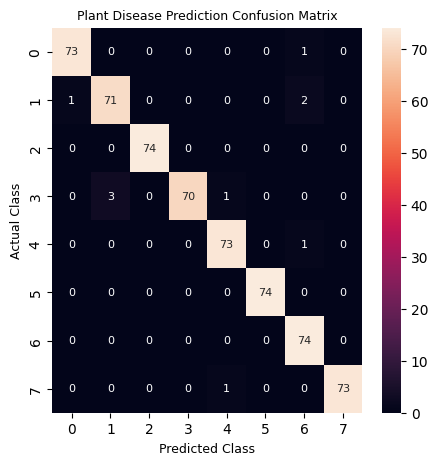

In [64]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm,annot=True,annot_kws={"size": 8})

plt.xlabel('Predicted Class',fontsize = 9)
plt.ylabel('Actual Class',fontsize = 9)
plt.title('Plant Disease Prediction Confusion Matrix',fontsize = 9)
plt.show()

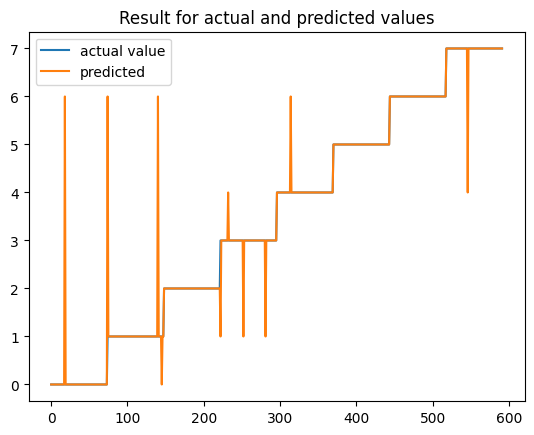

In [65]:
#Plot actual value againt the predicted value
x_ax = range(len(actual_categories))
plt.plot(x_ax, actual_categories, label = 'actual value')
plt.plot(x_ax, predicted_categories, label= 'predicted')
plt.title('Result for actual and predicted values')
plt.legend()
plt.show()

TRANSFER LEARNING MODELS FOR COMPARISON



TRANSFER LEARNING MODEL VGG16 BUILDING

In [66]:
# Load the VGG16 model with pre-trained weights, excluding the top layers
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom top layers for classification
x = base_model_vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)

# Combine the base model and custom layers into a new model
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model_vgg16.layers:
    layer.trainable = False

# Compile the model
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [67]:
# Train the VGG16 model
history_vgg16 = model_vgg16.fit(training_set, validation_data=validation_set, epochs=30)



Epoch 1/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - accuracy: 0.6601 - loss: 1.8110 - val_accuracy: 0.8305 - val_loss: 0.5777
Epoch 2/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 35s 60ms/step - accuracy: 0.8681 - loss: 0.3880 - val_accuracy: 0.8783 - val_loss: 0.4037
Epoch 3/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9325 - loss: 0.1919 - val_accuracy: 0.8840 - val_loss: 0.4099
Epoch 4/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.9510 - loss: 0.1404 - val_accuracy: 0.8835 - val_loss: 0.3772
Epoch 5/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9605 - loss: 0.1065 - val_accuracy: 0.8703 - val_loss: 0.4361
Epoch 6/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.9707 - loss: 0.0798 - val_accuracy: 0.8868 - val_loss: 0.4005
Epoch 7/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.9789 - loss: 0.0582 - val_accuracy: 0.8854 - val_loss: 0.4002
Epoch 8/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.9830 - loss: 0.0503 - 

In [68]:
#Use the model to predict target labels
y_pred = model_vgg16.predict(test_set)
predicted_categories = tf.argmax(y_pred, axis=1)


592/592 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


In [69]:
#TO generate actual labels from test set
Y_true = tf.concat([y for x, y in test_set], axis=0)
Maxvalue = tf.argmax(Y_true, axis=1)
actual_categories = Maxvalue.numpy()

In [70]:
#actual_categories

In [71]:
#predicted_categories = predicted_categories.numpy()
#predicted_categories

In [72]:
from sklearn import metrics
print("Accuracy =", metrics.accuracy_score(actual_categories, predicted_categories))

Accuracy = 0.9425675675675675


In [73]:
#To show the prediction and the confidence level
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]

    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [74]:
#Show actual value and predicted value in dataframe
view_pred = pd.DataFrame(list(zip(predicted_categories, actual_categories)))
view_pred.columns = ['Prediction', 'Actual values']
view_pred.tail(30)

,Prediction,Actual values
562,"tf.Tensor(7, shape=(), dtype=int64)",7
563,"tf.Tensor(7, shape=(), dtype=int64)",7
564,"tf.Tensor(7, shape=(), dtype=int64)",7
565,"tf.Tensor(7, shape=(), dtype=int64)",7
566,"tf.Tensor(7, shape=(), dtype=int64)",7
567,"tf.Tensor(7, shape=(), dtype=int64)",7
568,"tf.Tensor(7, shape=(), dtype=int64)",7
569,"tf.Tensor(7, shape=(), dtype=int64)",7
570,"tf.Tensor(7, shape=(), dtype=int64)",7
571,"tf.Tensor(7, shape=(), dtype=int64)",7


In [75]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(actual_categories,predicted_categories)

In [76]:
# Precision Recall Fscore
print(classification_report(actual_categories,predicted_categories,target_names=class_names))

                  precision    recall  f1-score   support

  bacterial spot       0.97      0.97      0.97        74
    early blight       0.92      0.93      0.93        74
         healthy       0.99      0.95      0.97        74
     late blight       0.88      0.91      0.89        74
       leaf mold       0.91      0.96      0.93        74
    mosaic virus       0.96      1.00      0.98        74
   septoria spot       0.93      0.84      0.88        74
yellow leaf curl       0.99      0.99      0.99        74

        accuracy                           0.94       592
       macro avg       0.94      0.94      0.94       592
    weighted avg       0.94      0.94      0.94       592



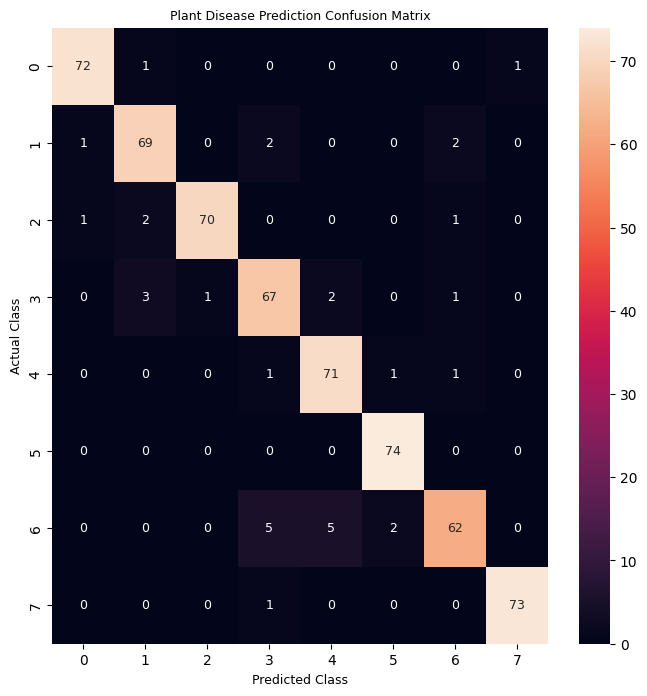

In [77]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm,annot=True,annot_kws={"size": 9})

plt.xlabel('Predicted Class',fontsize = 9)
plt.ylabel('Actual Class',fontsize = 9)
plt.title('Plant Disease Prediction Confusion Matrix',fontsize = 9)
plt.show()

TRANSFER LEARNING MOEL BUILDING USING RESNET

In [78]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Load the ResNet50 model with pre-trained weights, excluding the top layers
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom top layers for classification
x = base_model_resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)

# Combine the base model and custom layers into a new model
model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model_resnet50.layers:
    layer.trainable = False

# Compile the model
model_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [79]:
#Train the ResNet50 model
history_resnet50 = model_resnet50.fit(training_set, validation_data=validation_set, epochs=30)


Epoch 1/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.7068 - loss: 1.0642 - val_accuracy: 0.9053 - val_loss: 0.2745
Epoch 2/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.9347 - loss: 0.1890 - val_accuracy: 0.8873 - val_loss: 0.3595
Epoch 3/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.9648 - loss: 0.1173 - val_accuracy: 0.9105 - val_loss: 0.2915
Epoch 4/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9686 - loss: 0.0988 - val_accuracy: 0.9157 - val_loss: 0.2453
Epoch 5/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9802 - loss: 0.0645 - val_accuracy: 0.9446 - val_loss: 0.1789
Epoch 6/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9872 - loss: 0.0415 - val_accuracy: 0.9531 - val_loss: 0.1480
Epoch 7/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9750 - loss: 0.0665 - val_accuracy: 0.9366 - val_loss: 0.2120
Epoch 8/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9887 - loss: 0.0329 - 

MODEL EVALUATION

In [80]:
#Training set Accuracy
train_loss, train_acc = model_resnet50.evaluate(training_set)
print('Training accuracy:', train_acc)

264/264 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 1.0000 - loss: 2.5050e-05
Training accuracy: 1.0


In [81]:
#Validation set Accuracy
val_loss, val_acc = model_resnet50.evaluate(validation_set)
print('Validation accuracy:', val_acc)

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9666 - loss: 0.1614
Validation accuracy: 0.9607007503509521


SAVING MODEL

In [82]:
model_resnet50.save('trained_plant_disease_model_w_.keras')

In [83]:
history_resnet50.history #Return Dictionary of history

{'accuracy': [0.8206676244735718,
  0.9382102489471436,
  0.9607007503509521,
  0.9643702507019043,
  0.9837831258773804,
  0.9846117496490479,
  0.9837831258773804,
  0.9856770634651184,
  0.9822443127632141,
  0.9760890007019043,
  0.986268937587738,
  0.9881628751754761,
  0.9897016882896423,
  0.9919507503509521,
  0.9983428120613098,
  0.9998816251754761,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'loss': [0.5645968914031982,
  0.1784709244966507,
  0.11989007145166397,
  0.10350239276885986,
  0.052708376199007034,
  0.04775628075003624,
  0.04697378724813461,
  0.0392116904258728,
  0.05224747583270073,
  0.07009664922952652,
  0.040747806429862976,
  0.04074826091527939,
  0.029391199350357056,
  0.024090878665447235,
  0.007804221473634243,
  0.001245577703230083,
  0.00024644474615342915,
  0.00014243798796087503,
  0.0001129282100009732,
  9.465663606533781e-05,
  8.205766062019393e-05,
  7.20155585440807e-05,
  6.3335

In [84]:

#Recording History in json
import json
with open('history_resnet50.json','w') as f:
  json.dump(history_resnet50.history,f)

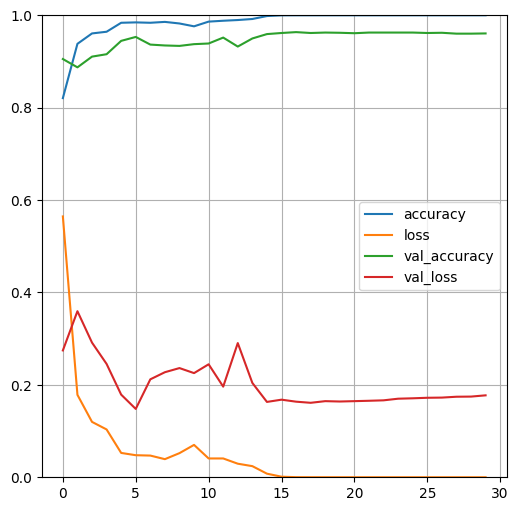

In [85]:
pd.DataFrame(history_resnet50.history).plot(figsize=(6,6))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [86]:
print(history_resnet50.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


ACCURACY AND LOSS VISUALIZATION

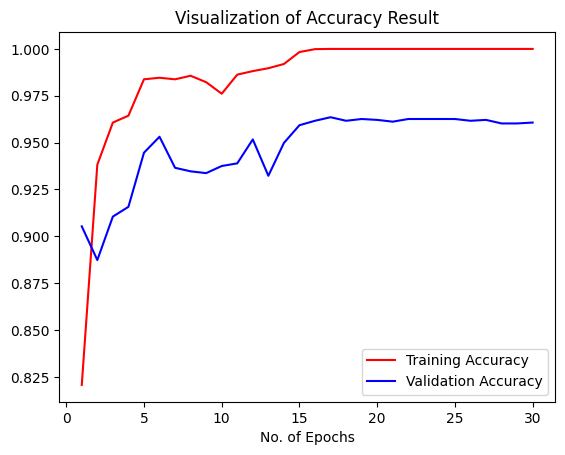

In [87]:
epochs = [i for i in range(1,31)]
plt.plot(epochs,history_resnet50.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(epochs,history_resnet50.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

In [88]:
#To plot loss and accuracy graph
acc = history_resnet50.history['accuracy']
val_acc = history_resnet50.history['val_accuracy']

loss = history_resnet50.history['loss']
val_loss = history_resnet50.history['val_loss']

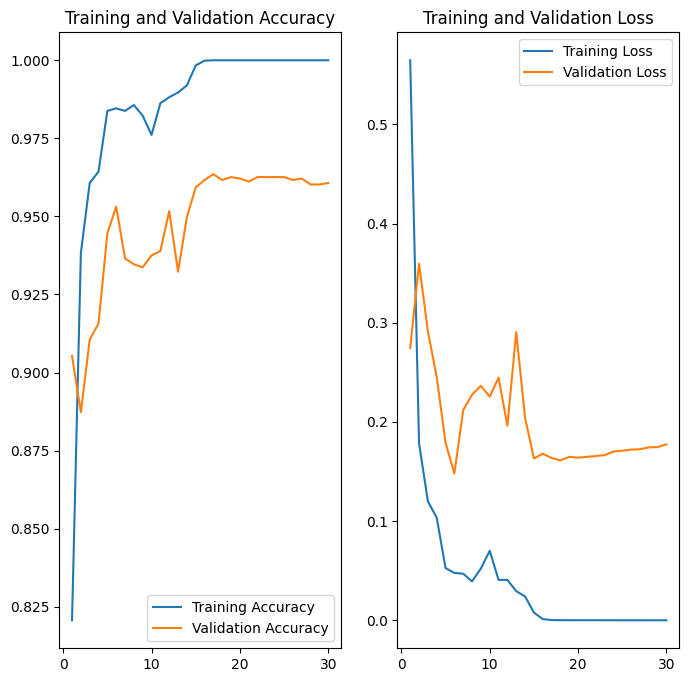

In [89]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(epochs, loss , label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

TO GENERATE TEST METRICS ON TEST DATA

In [90]:
#TO generate actual labels from test set
Y_true = tf.concat([y for x, y in test_set], axis=0)
Maxvalue = tf.argmax(Y_true, axis=1)
actual_categories = Maxvalue.numpy()

In [91]:
actual_categories

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,

In [92]:
predicted_categories = predicted_categories.numpy()
predicted_categories

array([0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 6, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 2, 2, 2, 6,
       0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 4, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,

In [93]:
from sklearn import metrics
print("Accuracy =", metrics.accuracy_score(actual_categories, predicted_categories))

Accuracy = 0.9425675675675675


In [94]:
#To show the prediction and the confidence level
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]

    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [95]:
#Show actual value and predicted value in dataframe
view_pred = pd.DataFrame(list(zip(predicted_categories, actual_categories)))
view_pred.columns = ['Prediction', 'Actual values']
view_pred.tail(30)

,Prediction,Actual values
562,7,7
563,7,7
564,7,7
565,7,7
566,7,7
567,7,7
568,7,7
569,7,7
570,7,7
571,7,7


In [96]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(actual_categories,predicted_categories)

In [97]:
# Precision Recall Fscore
print(classification_report(actual_categories,predicted_categories,target_names=class_names))

                  precision    recall  f1-score   support

  bacterial spot       0.97      0.97      0.97        74
    early blight       0.92      0.93      0.93        74
         healthy       0.99      0.95      0.97        74
     late blight       0.88      0.91      0.89        74
       leaf mold       0.91      0.96      0.93        74
    mosaic virus       0.96      1.00      0.98        74
   septoria spot       0.93      0.84      0.88        74
yellow leaf curl       0.99      0.99      0.99        74

        accuracy                           0.94       592
       macro avg       0.94      0.94      0.94       592
    weighted avg       0.94      0.94      0.94       592



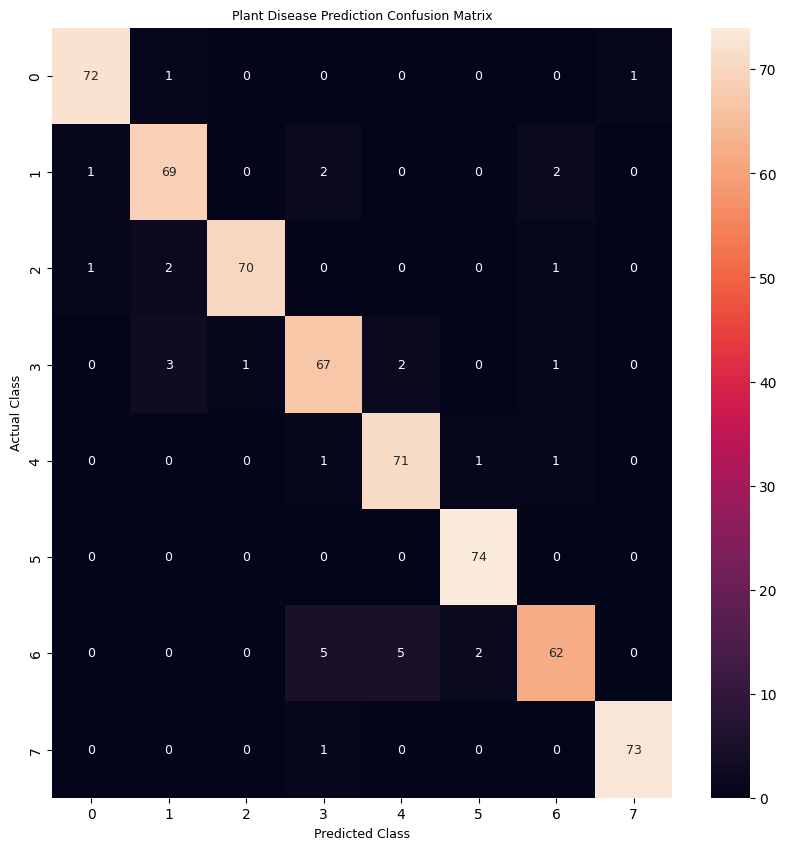

In [98]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm,annot=True,annot_kws={"size": 9})

plt.xlabel('Predicted Class',fontsize = 9)
plt.ylabel('Actual Class',fontsize = 9)
plt.title('Plant Disease Prediction Confusion Matrix',fontsize = 9)
plt.show()

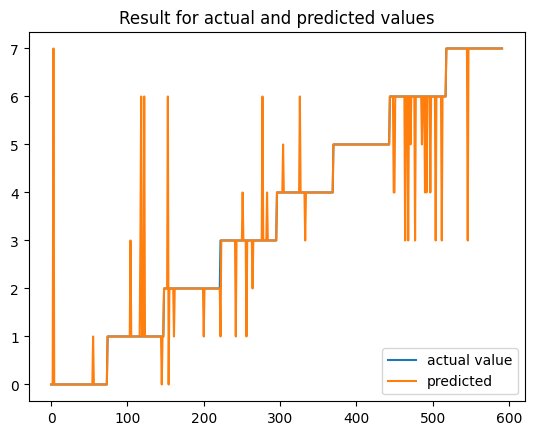

In [99]:
#Plot actual value againt the predicted value
x_ax = range(len(actual_categories))
plt.plot(x_ax, actual_categories, label = 'actual value')
plt.plot(x_ax, predicted_categories, label= 'predicted')
plt.title('Result for actual and predicted values')
plt.legend()
plt.show()